### A3: Predicting Car Price

Name: Muhammad Fahad Waqar<br>
Student No: 125981

### Github Repository Link
https://github.com/mfahadwaqar/st125981_ML_A3

In [37]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [38]:
# Loading Data
df = pd.read_csv("Cars.csv")    # Reading data from the csv file
print(df.head())

                           name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250N

In [39]:
# EDA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [40]:
df.shape    # Shape of the dataset

(8128, 13)

In [41]:
print(df.describe())  # Statistical summary of the dataset

              year  selling_price     km_driven        seats
count  8128.000000   8.128000e+03  8.128000e+03  7907.000000
mean   2013.804011   6.382718e+05  6.981951e+04     5.416719
std       4.044249   8.062534e+05  5.655055e+04     0.959588
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.800000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000


In [42]:
# Checking missing values in each column
df.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

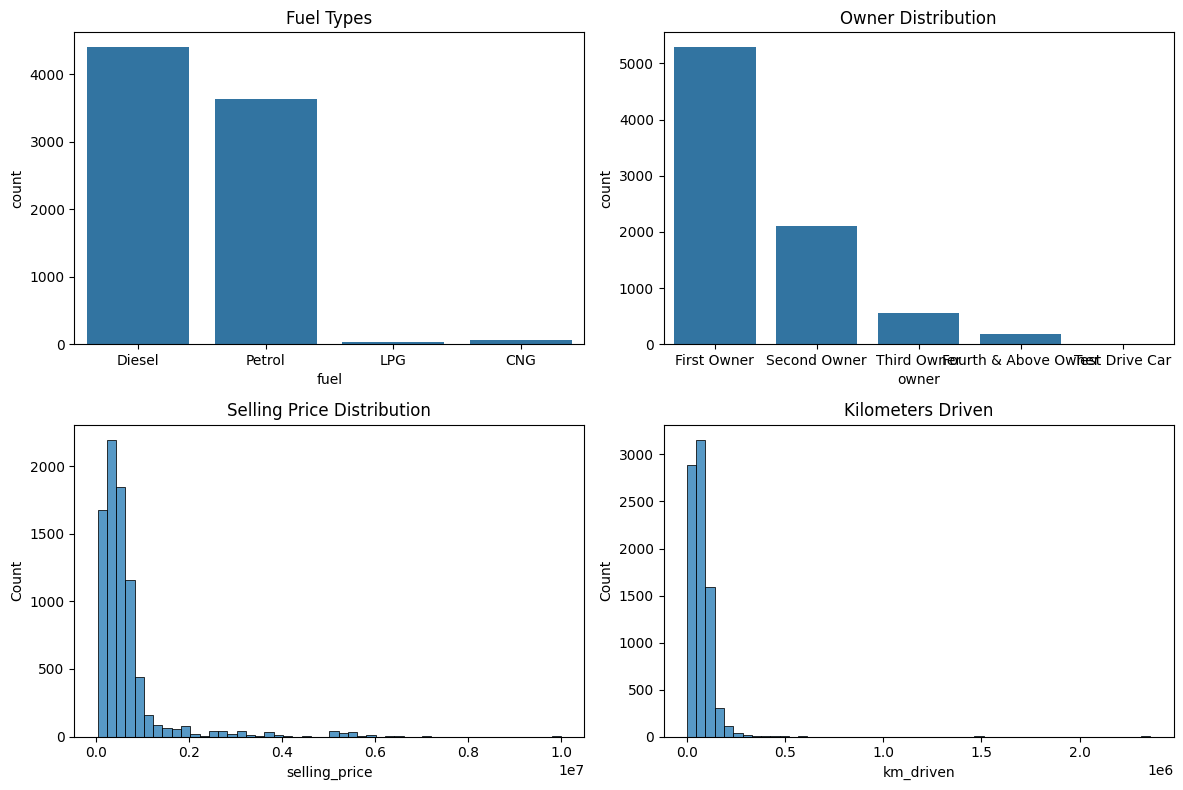

In [43]:
# Univariate Analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.countplot(x="fuel", data=df, ax=axes[0,0]).set_title("Fuel Types")
sns.countplot(x="owner", data=df, ax=axes[0,1]).set_title("Owner Distribution")
sns.histplot(df["selling_price"], bins=50, ax=axes[1,0]).set_title("Selling Price Distribution")
sns.histplot(df["km_driven"], bins=50, ax=axes[1,1]).set_title("Kilometers Driven")
plt.tight_layout()

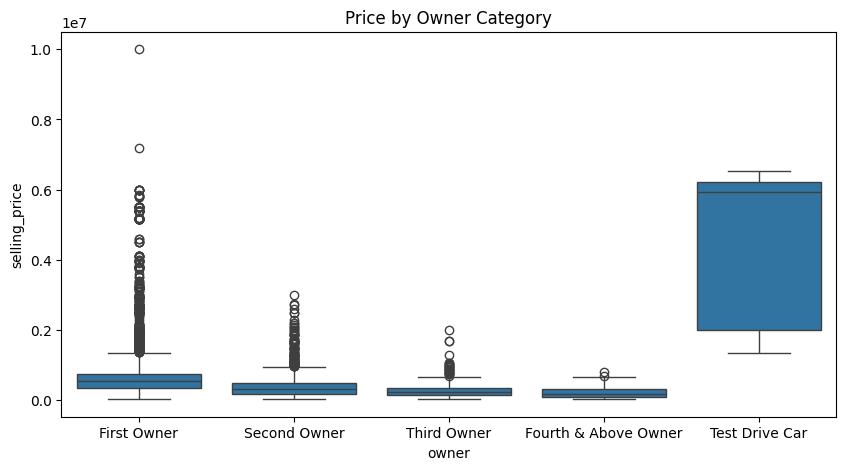

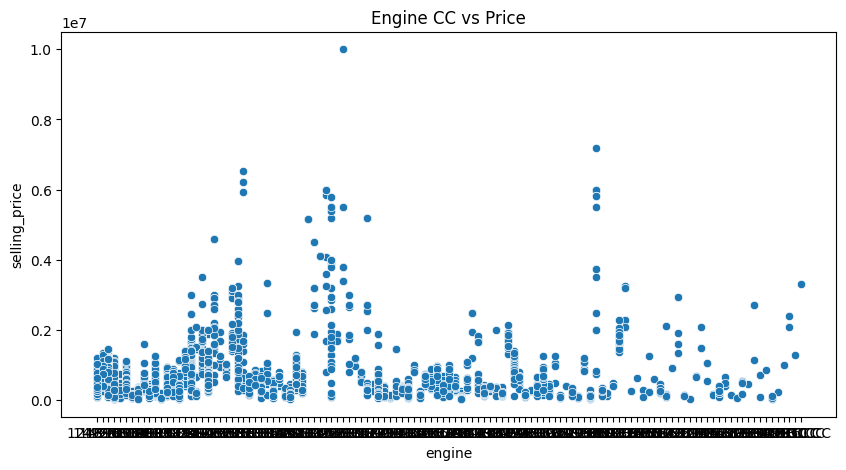

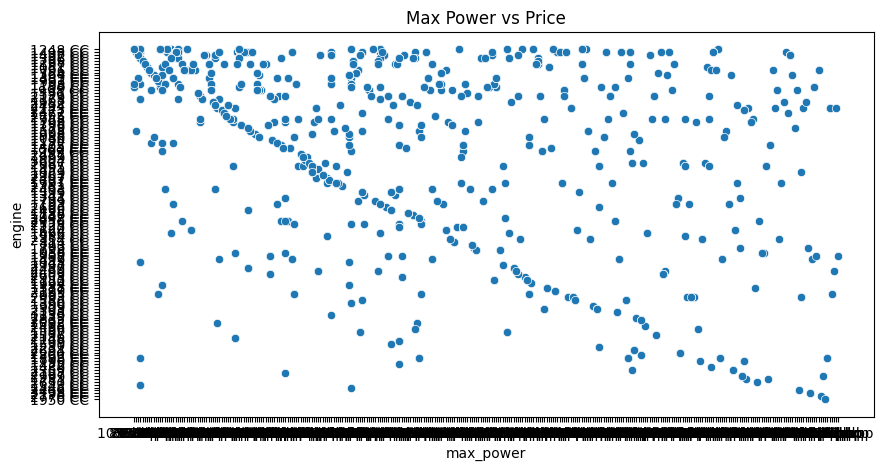

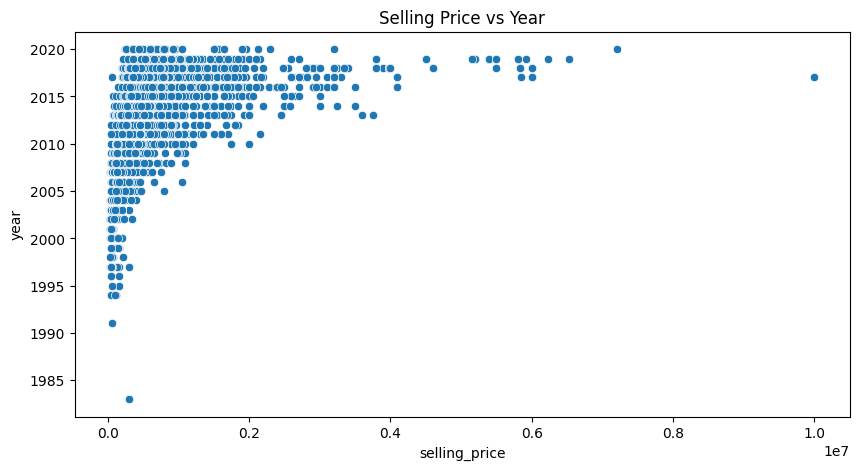

In [44]:
# Multivariate Analysis
plt.figure(figsize=(10, 5))
sns.boxplot(x="owner", y="selling_price", data=df).set_title("Price by Owner Category")
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x="engine", y="selling_price", data=df).set_title("Engine CC vs Price")
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x="max_power", y="engine", data=df).set_title("Max Power vs Price")
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x="selling_price", y="year", data=df).set_title("Selling Price vs Year")
plt.show()

<Axes: >

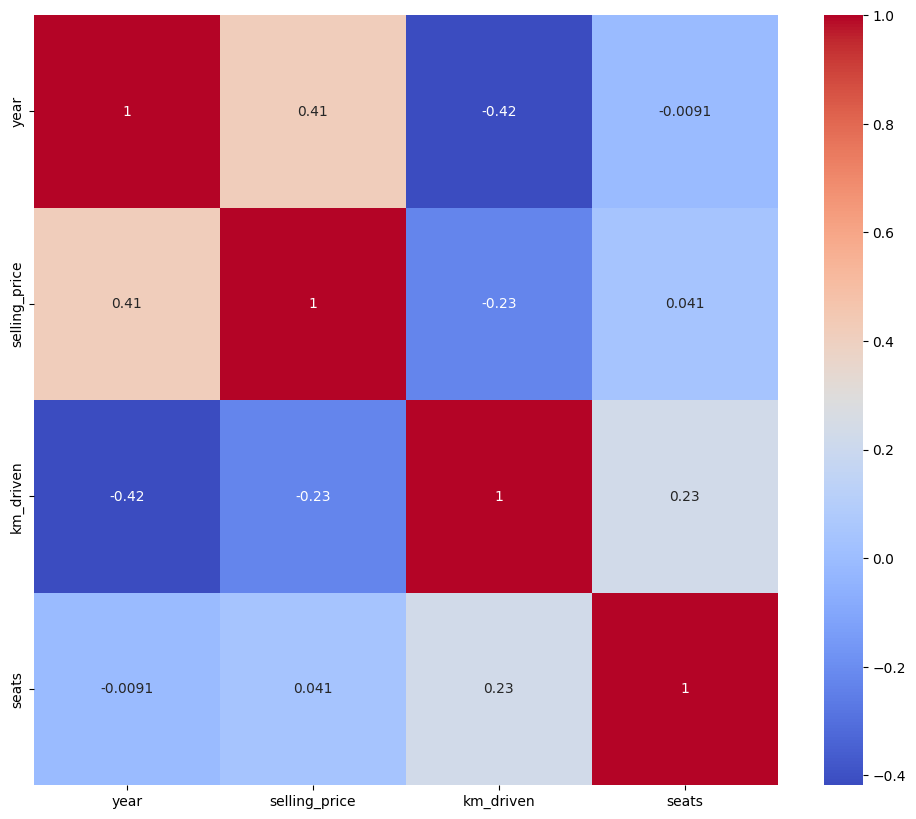

In [45]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')

<Axes: xlabel='x', ylabel='y'>

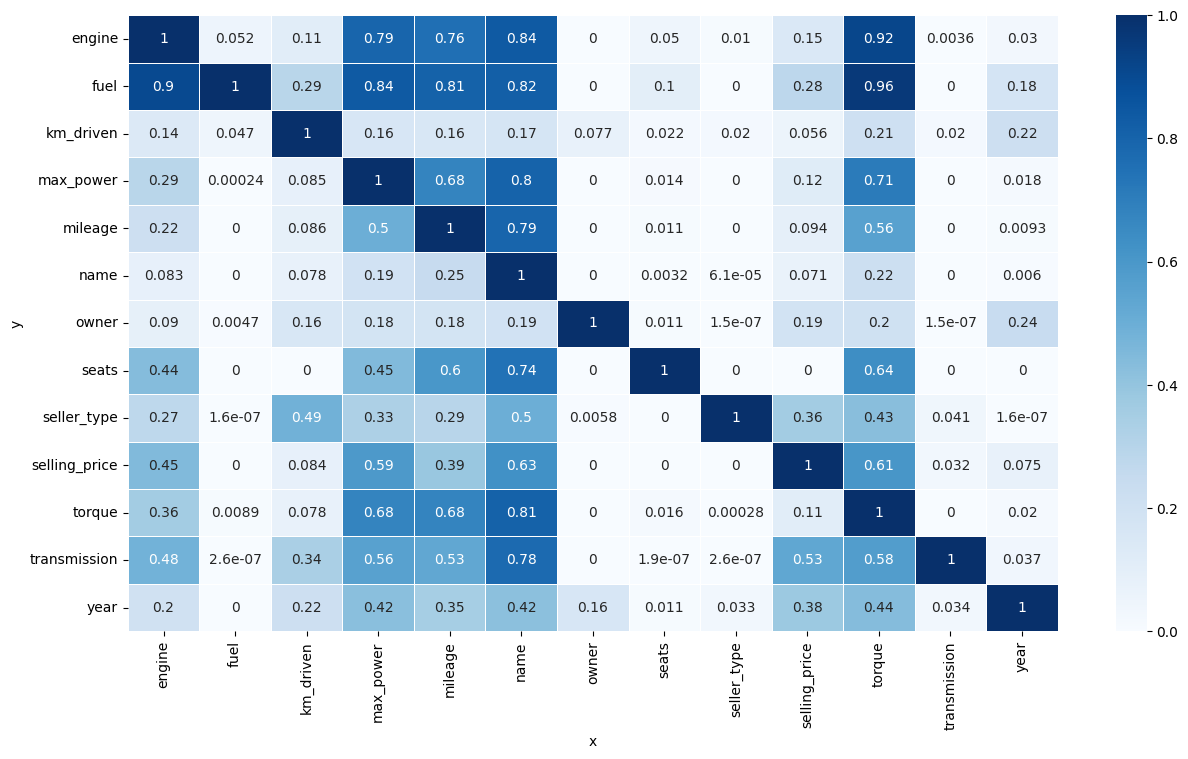

In [46]:
import ppscore as pps

matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

#plot
plt.figure(figsize=(15, 8))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

In [47]:
# Feature Selection
# Creating a function for data cleaning and feature engineering to be used after data splitting
def clean_data(df):
    df = df.copy()

    # Drop torque column
    if "torque" in df.columns:
        df.drop(columns="torque", inplace=True)

    # Remove CNG and LPG
    df = df[~df["fuel"].isin(["CNG", "LPG"])]

    # Remove Test Drive Car from owner
    df = df[df["owner"] != "Test Drive Car"]

    # Convert mileage, engine, max_power to numeric
    df["mileage"] = df["mileage"].str.extract(r'(\d+\.?\d*)').astype(float)
    df["engine"] = df["engine"].str.extract(r'(\d+\.?\d*)').astype(float)
    df["max_power"] = df["max_power"].str.extract(r'(\d+\.?\d*)').astype(float)

    # Extract brand name
    if "name" in df.columns:
        df["brand"] = df["name"].str.split(" ").str[0]

    # Map owner to numeric
    owner_mapping = {
        "First Owner": 1,
        "Second Owner": 2,
        "Third Owner": 3,
        "Fourth & Above Owner": 4
    }
    df["owner"] = df["owner"].map(owner_mapping)

    return df

In [48]:
# Splitting into train and test sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Applying the cleaning function to both splits
train_df_clean = clean_data(train_df)
test_df_clean = clean_data(test_df)

# Seperating features and targets
X_train = train_df_clean[["year", "km_driven", "mileage", "engine", "max_power", "transmission", "owner", "brand"]]
y_train = np.log(train_df_clean["selling_price"])

X_test = test_df_clean[["year", "km_driven", "mileage", "engine", "max_power", "transmission", "owner", "brand"]]
y_test = np.log(test_df_clean["selling_price"])

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (7229, 8) Test shape: (799, 8)


In [49]:
# Preprocessing
# Rearranging columns
cols = X_train.columns.tolist()
cols.insert(0, cols.pop(cols.index('brand')))
X_train = X_train[cols]

In [50]:
cols = X_test.columns.tolist()
cols.insert(0, cols.pop(cols.index('brand')))
X_test = X_test[cols]

In [51]:
print(X_train.head())

         brand  year  km_driven  mileage  engine  max_power transmission  \
7287  Mahindra  2019      17000    17.30  1497.0      121.0       Manual   
3027    Maruti  2016     120000    26.59  1248.0       74.0       Manual   
2941    Maruti  2012     100000    19.10  1197.0       85.8       Manual   
4269       BMW  2019       7500    16.78  1995.0      190.0    Automatic   
3182  Mahindra  2017      88754    16.00  2179.0      140.0       Manual   

      owner  
7287      1  
3027      3  
2941      1  
4269      1  
3182      1  


In [52]:
numeric_features = ["year", "km_driven", "mileage", "engine", "max_power"]
categorical_features = ["brand", "transmission", "owner"]

# Split data into numeric and categorical subsets
X_train_num = X_train[numeric_features].copy()
X_test_num  = X_test[numeric_features].copy()

X_train_cat = X_train[categorical_features].copy()
X_test_cat  = X_test[categorical_features].copy()

# Imputation and Scaling for numeric features
num_medians = X_train_num.median()
X_train_num = X_train_num.fillna(num_medians)
X_test_num  = X_test_num.fillna(num_medians)

scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_num),
    columns=numeric_features,
    index=X_train.index
)
X_test_num_scaled = pd.DataFrame(
    scaler.transform(X_test_num),
    columns=numeric_features,
    index=X_test.index
)

# Imputation and Encoding for categorical features
cat_modes = X_train_cat.mode().iloc[0]
X_train_cat = X_train_cat.fillna(cat_modes)
X_test_cat  = X_test_cat.fillna(cat_modes)

encode = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
X_train_cat_ohe = pd.DataFrame(
    encode.fit_transform(X_train_cat),
    columns=encode.get_feature_names_out(categorical_features),
    index=X_train.index
)
X_test_cat_ohe = pd.DataFrame(
    encode.transform(X_test_cat),
    columns=encode.get_feature_names_out(categorical_features),
    index=X_test.index
)

# Putting the processed data back together 
X_train = pd.concat([X_train_num_scaled, X_train_cat_ohe], axis=1)
X_test  = pd.concat([X_test_num_scaled,  X_test_cat_ohe],  axis=1)

print("Processed train shape:", X_train.shape)
print("Processed test  shape:", X_test.shape)

Processed train shape: (7229, 40)
Processed test  shape: (799, 40)


## Task 1: Classification & Task 2: Ridge Logistic Regression

In [53]:
# Converting selling_price to 4 discrtete classes

# Converting selling_price back from log space to original prices for binning
train_prices_original = np.exp(y_train)
test_prices_original = np.exp(y_test)

# Making 4 bins for classification
bins = pd.qcut(train_prices_original, q=4, labels=[0, 1, 2, 3], duplicates='drop')
y_train_class = bins.astype(int)

# Applying the same to test set
bin_edges = pd.qcut(train_prices_original, q=4, duplicates='drop', retbins=True)[1]
y_test_class = pd.cut(test_prices_original, bins=bin_edges, labels=[0, 1, 2, 3], include_lowest=True).astype(int)

print(f"Class distribution in training set:")
print(y_train_class.value_counts().sort_index())
print(f"\nClass distribution in test set:")
print(y_test_class.value_counts().sort_index())

Class distribution in training set:
selling_price
0    1849
1    1841
2    1743
3    1796
Name: count, dtype: int64

Class distribution in test set:
selling_price
0    201
1    203
2    200
3    195
Name: count, dtype: int64


In [54]:
# Multinomial Logistic Regression Implemetation
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iterations=1000, regularization=None, lambda_reg=0.01):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.W = None
        self.losses = []
        
    def softmax(self, theta_t_x):
        theta_t_x = np.array(theta_t_x)
        exp_vals = np.exp(theta_t_x - np.max(theta_t_x, axis=1, keepdims=True))
        return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)
    
    def h_theta(self, X, W):
        X = np.array(X)  # ← Added this line
        return self.softmax(X @ W)
    
    def gradient(self, X, Y):
        m = X.shape[0]
        h = self.h_theta(X, self.W)
        
        # Cross-entropy loss
        loss = -np.sum(Y * np.log(h + 1e-8)) / m
        
        if self.regularization == 'ridge':
            loss += self.lambda_reg * np.sum(self.W ** 2) / (2 * m)
        
        # Compute gradient
        error = h - Y
        grad = X.T @ error / m
        
        if self.regularization == 'ridge':
            grad += self.lambda_reg * self.W / m
            
        return loss, grad
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        # Get dimensions
        m, n = X.shape
        k = len(np.unique(y))  # number of classes
        
        # Initialize weights
        self.W = np.random.normal(0, 0.01, (n, k))
        
        # Convert y to one-hot encoding
        Y_encoded = np.zeros((m, k))
        for i, label in enumerate(y):
            Y_encoded[i, label] = 1
        
        # Training loop
        self.losses = []
        for i in range(self.max_iterations):
            loss, grad = self.gradient(X, Y_encoded)
            self.losses.append(loss)
            self.W = self.W - self.learning_rate * grad
            
            if i % 100 == 0:
                print(f"Loss at iteration {i}: {loss}")
    
    def predict(self, X):
        X = np.array(X)
        return np.argmax(self.h_theta(X, self.W), axis=1)

    def predict_proba(self, X):
        X = np.array(X)
        return self.h_theta(X, self.W)
    
    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses)
        plt.title('Training Loss Over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Cross-Entropy Loss')
        plt.grid(True)
        plt.show()

In [55]:
# Evaluation Metrics
class ClassificationMetrics:
    def __init__(self, y_true, y_pred, classes=None):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.classes = classes if classes is not None else np.unique(np.concatenate([y_true, y_pred]))
        self.n_classes = len(self.classes)
        self._compute_confusion_matrix()
    
    def _compute_confusion_matrix(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes), dtype=int)
        for i, true_class in enumerate(self.classes):
            for j, pred_class in enumerate(self.classes):
                self.confusion_matrix[i, j] = np.sum((self.y_true == true_class) & (self.y_pred == pred_class))
    
    def accuracy(self):
        correct_predictions = np.sum(self.y_true == self.y_pred)
        total_predictions = len(self.y_true)
        return correct_predictions / total_predictions
    
    def precision(self, class_idx=None):
        if class_idx is not None:
            tp = self.confusion_matrix[class_idx, class_idx]
            fp = np.sum(self.confusion_matrix[:, class_idx]) - tp
            return tp / (tp + fp) if (tp + fp) > 0 else 0.0
        else:
            precisions = []
            for i in range(self.n_classes):
                precisions.append(self.precision(i))
            return np.array(precisions)
    
    def recall(self, class_idx=None):
        if class_idx is not None:
            tp = self.confusion_matrix[class_idx, class_idx]
            fn = np.sum(self.confusion_matrix[class_idx, :]) - tp
            return tp / (tp + fn) if (tp + fn) > 0 else 0.0
        else:
            recalls = []
            for i in range(self.n_classes):
                recalls.append(self.recall(i))
            return np.array(recalls)
    
    def f1_score(self, class_idx=None):
        if class_idx is not None:
            prec = self.precision(class_idx)
            rec = self.recall(class_idx)
            return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0
        else:
            f1_scores = []
            for i in range(self.n_classes):
                f1_scores.append(self.f1_score(i))
            return np.array(f1_scores)
    
    def macro_precision(self):
        precisions = self.precision()
        return np.mean(precisions)
    
    def macro_recall(self):
        recalls = self.recall()
        return np.mean(recalls)
    
    def macro_f1(self):
        f1_scores = self.f1_score()
        return np.mean(f1_scores)
    
    def weighted_precision(self):
        precisions = self.precision()
        support = [np.sum(self.y_true == class_label) for class_label in self.classes]
        total_support = np.sum(support)
        weights = [s / total_support for s in support]
        return np.sum([w * p for w, p in zip(weights, precisions)])
    
    def weighted_recall(self):
        recalls = self.recall()
        support = [np.sum(self.y_true == class_label) for class_label in self.classes]
        total_support = np.sum(support)
        weights = [s / total_support for s in support]
        return np.sum([w * r for w, r in zip(weights, recalls)])
    
    def weighted_f1(self):
        f1_scores = self.f1_score()
        support = [np.sum(self.y_true == class_label) for class_label in self.classes]
        total_support = np.sum(support)
        weights = [s / total_support for s in support]
        return np.sum([w * f for w, f in zip(weights, f1_scores)])
    
    def classification_report(self):
        support = [np.sum(self.y_true == class_label) for class_label in self.classes]
        
        print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
        print("-" * 50)
        
        precisions = self.precision()
        recalls = self.recall()
        f1_scores = self.f1_score()
        
        for i, class_label in enumerate(self.classes):
            print(f"{class_label:<10} {precisions[i]:<10.3f} {recalls[i]:<10.3f} {f1_scores[i]:<10.3f} {support[i]:<10}")
        
        print("-" * 50)
        print(f"{'Accuracy':<10} {'':<10} {'':<10} {self.accuracy():<10.3f} {np.sum(support):<10}")
        print(f"{'Macro Avg':<10} {self.macro_precision():<10.3f} {self.macro_recall():<10.3f} {self.macro_f1():<10.3f} {np.sum(support):<10}")
        print(f"{'Weighted Avg':<10} {self.weighted_precision():<10.3f} {self.weighted_recall():<10.3f} {self.weighted_f1():<10.3f} {np.sum(support):<10}")

Training custom Logistic Regression...
Loss at iteration 0: 1.3840307045241076
Loss at iteration 100: 1.1802860057536837
Loss at iteration 200: 1.084184448588857
Loss at iteration 300: 1.028002722695251
Loss at iteration 400: 0.9896152504095714
Custom Implementation Results
Class      Precision  Recall     F1-Score   Support   
--------------------------------------------------
0          0.651      0.935      0.767      201       
1          0.557      0.335      0.418      203       
2          0.485      0.415      0.447      200       
3          0.659      0.733      0.694      195       
--------------------------------------------------
Accuracy                         0.603      799       
Macro Avg  0.588      0.605      0.582      799       
Weighted Avg 0.588      0.603      0.581      799       


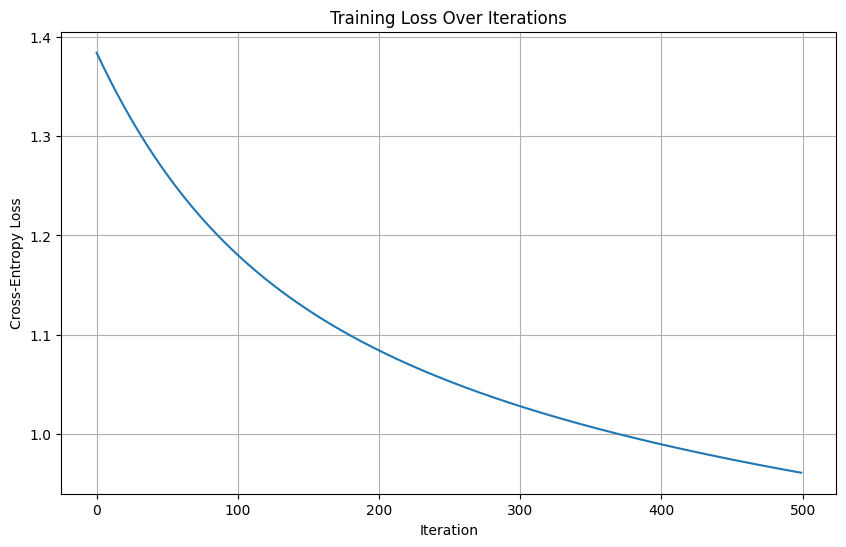

Comparing with sklearn
Sklearn Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       201
           1       0.61      0.60      0.60       203
           2       0.55      0.62      0.58       200
           3       0.83      0.75      0.79       195

    accuracy                           0.70       799
   macro avg       0.71      0.70      0.70       799
weighted avg       0.71      0.70      0.70       799



In [56]:
# Testing Implementation
# Training custom model
print("Training custom Logistic Regression...")
custom_model = LogisticRegression(learning_rate=0.01, max_iterations=500)
custom_model.fit(X_train, y_train_class)

# Make predictions
y_pred_custom = custom_model.predict(X_test)

# Evaluate with custom metrics
print("Custom Implementation Results")
custom_metrics = ClassificationMetrics(y_test_class, y_pred_custom)
custom_metrics.classification_report()

# Plot training loss
custom_model.plot_losses()

# Compare with sklearn
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.metrics import classification_report

print("Comparing with sklearn")
sklearn_model = SklearnLogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
sklearn_model.fit(X_train, y_train_class)
y_pred_sklearn = sklearn_model.predict(X_test)

print("Sklearn Classification Report:")
print(classification_report(y_test_class, y_pred_sklearn))

In [57]:
# Ridge Logistic Regression Test
print("Ridge Logistic Regression Test")

# Train with Ridge regularization
ridge_model = LogisticRegression(learning_rate=0.01, max_iterations=500, 
                                regularization='ridge', lambda_reg=0.1)
ridge_model.fit(X_train, y_train_class)
y_pred_ridge = ridge_model.predict(X_test)

ridge_metrics = ClassificationMetrics(y_test_class, y_pred_ridge)
print("Ridge Regularized Results:")
ridge_metrics.classification_report()

Ridge Logistic Regression Test
Loss at iteration 0: 1.390120576275421
Loss at iteration 100: 1.1840401718231859
Loss at iteration 200: 1.086821503984475
Loss at iteration 300: 1.0300346672984226
Loss at iteration 400: 0.9912695053227906
Ridge Regularized Results:
Class      Precision  Recall     F1-Score   Support   
--------------------------------------------------
0          0.651      0.935      0.767      201       
1          0.558      0.355      0.434      203       
2          0.482      0.400      0.437      200       
3          0.656      0.723      0.688      195       
--------------------------------------------------
Accuracy                         0.602      799       
Macro Avg  0.587      0.603      0.582      799       
Weighted Avg 0.586      0.602      0.581      799       


## Task 3: Deployment

In [58]:
# MLFlow Experiment Logging
import mlflow
import mlflow.sklearn
from sklearn.model_selection import cross_val_score
import pickle
import os

In [61]:
# Setup MLflow tracking with authentication
mlflow.set_tracking_uri("http://mlflow.ml.brain.cs.ait.ac.th/")

# Set authentication credentials (from A2 instructions: username='admin', password='password')
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'password'

mlflow.set_experiment("st125981-a3")  # Replace st125981 with your student ID

def log_model_experiment(model, model_name, X_train, X_test, y_train, y_test, params):
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        for key, value in params.items():
            mlflow.log_param(key, value)

        # Log the trained model (so it can be registered later)
        mlflow.sklearn.log_model(model, artifact_path="model")

        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics using your custom implementation
        metrics_calc = ClassificationMetrics(y_test, y_pred)
        
        # Log all metrics to MLflow
        mlflow.log_metric("accuracy", metrics_calc.accuracy())
        mlflow.log_metric("macro_precision", metrics_calc.macro_precision())
        mlflow.log_metric("macro_recall", metrics_calc.macro_recall())
        mlflow.log_metric("macro_f1", metrics_calc.macro_f1())
        mlflow.log_metric("weighted_precision", metrics_calc.weighted_precision())
        mlflow.log_metric("weighted_recall", metrics_calc.weighted_recall())
        mlflow.log_metric("weighted_f1", metrics_calc.weighted_f1())
        
        # Log per-class metrics
        precisions = metrics_calc.precision()
        recalls = metrics_calc.recall()
        f1_scores = metrics_calc.f1_score()
        
        for i, class_label in enumerate(metrics_calc.classes):
            mlflow.log_metric(f"precision_class_{class_label}", precisions[i])
            mlflow.log_metric(f"recall_class_{class_label}", recalls[i])
            mlflow.log_metric(f"f1_class_{class_label}", f1_scores[i])
        
        print(f"Logged {model_name} - Run ID: {mlflow.active_run().info.run_id}")
        return mlflow.active_run().info.run_id

In [ ]:
# Experiment 1: Basic Logistic Regression
print("Experiment 1: Basic Logistic Regression")
basic_model = LogisticRegression(learning_rate=0.01, max_iterations=500, regularization=None)
basic_model.fit(X_train, y_train_class)

basic_params = {
    "model_type": "LogisticRegression",
    "learning_rate": 0.01,
    "max_iterations": 500,
    "regularization": "none",
    "lambda_reg": 0.0
}

basic_run_id = log_model_experiment(
    basic_model, "basic_logistic_regression", 
    X_train, X_test, y_train_class, y_test_class, 
    basic_params
)

# Experiment 2: Ridge Logistic Regression
print("\nExperiment 2: Ridge Logistic Regression")
ridge_model = LogisticRegression(learning_rate=0.01, max_iterations=500, 
                                regularization='ridge', lambda_reg=0.1)
ridge_model.fit(X_train, y_train_class)

ridge_params = {
    "model_type": "LogisticRegression", 
    "learning_rate": 0.01,
    "max_iterations": 500,
    "regularization": "ridge",
    "lambda_reg": 0.1
}

ridge_run_id = log_model_experiment(
    ridge_model, "ridge_logistic_regression", 
    X_train, X_test, y_train_class, y_test_class, 
    ridge_params
)

# Experiment 3: Different Learning Rates
print("\nExperiment 3: Testing Different Learning Rates")
learning_rates = [0.001, 0.01, 0.1]

for lr in learning_rates:
    print(f"Testing learning_rate={lr}")
    
    temp_model = LogisticRegression(learning_rate=lr, max_iterations=500)
    temp_model.fit(X_train, y_train_class)
    
    temp_params = {
        "model_type": "LogisticRegression",
        "learning_rate": lr,
        "max_iterations": 500,
        "regularization": "none",
        "lambda_reg": 0.0
    }
    
    log_model_experiment(
        temp_model, f"logistic_regression_lr_{lr}", 
        X_train, X_test, y_train_class, y_test_class, 
        temp_params
    )

# Experiment 4: Different Regularization Strengths
print("\nExperiment 4: Testing Different Regularization Strengths")
lambda_values = [0.01, 0.1, 1.0]

for lam in lambda_values:
    print(f"Testing lambda={lam}")

    temp_model = LogisticRegression(learning_rate=0.01, max_iterations=500,
                                   regularization='ridge', lambda_reg=lam)
    temp_model.fit(X_train, y_train_class)
    
    temp_params = {
        "model_type": "LogisticRegression",
        "learning_rate": 0.01,
        "max_iterations": 500,
        "regularization": "ridge",
        "lambda_reg": lam
    }
    
    log_model_experiment(
        temp_model, f"ridge_logistic_regression_lambda_{lam}", 
        X_train, X_test, y_train_class, y_test_class, 
        temp_params
    )

# Experiment 5: Different Max Iterations
print("\nExperiment 5: Testing Different Max Iterations")
max_iterations = [100, 500, 1000]

for max_iter in max_iterations:
    print(f"Testing max_iterations={max_iter}")
    
    temp_model = LogisticRegression(learning_rate=0.01, max_iterations=max_iter)
    temp_model.fit(X_train, y_train_class)
    
    temp_params = {
        "model_type": "LogisticRegression",
        "learning_rate": 0.01,
        "max_iterations": max_iter,
        "regularization": "none",
        "lambda_reg": 0.0
    }
    
    log_model_experiment(
        temp_model, f"logistic_regression_maxiter_{max_iter}", 
        X_train, X_test, y_train_class, y_test_class, 
        temp_params
    )

print(f"View results at: http://mlflow.ml.brain.cs.ait.ac.th/")
print(f"Experiment name: st125981-a3")

print("Finding and registering best model...")

# Get all runs from the experiment
experiment = mlflow.get_experiment_by_name("st125981-a3")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Find the best run based on weighted_f1 score
best_run = runs.loc[runs['metrics.weighted_f1'].idxmax()]
best_run_id = best_run['run_id']
best_weighted_f1 = best_run['metrics.weighted_f1']

print(f"\nBest model found:")
print(f"  Run ID: {best_run_id}")
print(f"  Run Name: {best_run['tags.mlflow.runName']}")
print(f"  Weighted F1: {best_weighted_f1:.4f}")
print(f"  Accuracy: {best_run['metrics.accuracy']:.4f}")

from mlflow import MlflowClient

client = MlflowClient()
model_name = "st125981_best_logistic_regression"

# Register the best model from its run ID
model_uri = f"runs:/{best_run_id}/model"

# Register a new version
model_version = mlflow.register_model(model_uri=model_uri, name=model_name)

# Wait for the registration to complete (optional)
import time
time.sleep(5)

# Assign or update the alias (e.g., "Staging")
client.set_registered_model_alias(model_name, "Staging", model_version.version)

print(f"\nBest model registered successfully!")
print(f"Model Name: {model_name}")
print(f"Model Version: {model_version.version}")
print(f"Alias: Staging")
print(f"MLflow URL: http://mlflow.ml.brain.cs.ait.ac.th/#/models/{model_name}")

Experiment 1: Basic Logistic Regression
Loss at iteration 0: 1.3952661230561991
Loss at iteration 100: 1.1855473260017506
Loss at iteration 200: 1.0869718985599426
Loss at iteration 300: 1.0296683778895568
Loss at iteration 400: 0.990682469274693


2025/10/04 17:35:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 17:35:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/04 17:35:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged basic_logistic_regression - Run ID: 5b1fecb19ac0473d9d10773e5a9ab000
🏃 View run basic_logistic_regression at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407/runs/5b1fecb19ac0473d9d10773e5a9ab000
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407

Experiment 2: Ridge Logistic Regression
Loss at iteration 0: 1.384708515079588
Loss at iteration 100: 1.1821779835479942
Loss at iteration 200: 1.0862831863873634
Loss at iteration 300: 1.0299207655820624
Loss at iteration 400: 0.9912919301327046


2025/10/04 17:36:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 17:36:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/04 17:36:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged ridge_logistic_regression - Run ID: 6fd556ffe509429ca77adc4cd351e8c5
🏃 View run ridge_logistic_regression at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407/runs/6fd556ffe509429ca77adc4cd351e8c5
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407

Experiment 3: Testing Different Learning Rates
Testing learning_rate=0.001
Loss at iteration 0: 1.387765267225824
Loss at iteration 100: 1.3586839106171098
Loss at iteration 200: 1.3320109304683263
Loss at iteration 300: 1.3075514267319492
Loss at iteration 400: 1.2851135089502983


2025/10/04 17:36:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 17:36:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/04 17:36:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged logistic_regression_lr_0.001 - Run ID: 288b90b814544ede935c8ea0aa48d995
🏃 View run logistic_regression_lr_0.001 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407/runs/288b90b814544ede935c8ea0aa48d995
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407
Testing learning_rate=0.01
Loss at iteration 0: 1.3831223081282826
Loss at iteration 100: 1.181550377466806
Loss at iteration 200: 1.0857468433247324
Loss at iteration 300: 1.0294293709979594
Loss at iteration 400: 0.9908511114753946


2025/10/04 17:36:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 17:36:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/04 17:36:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged logistic_regression_lr_0.01 - Run ID: aabd2778112c426f9807fcb0ac2ca137
🏃 View run logistic_regression_lr_0.01 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407/runs/aabd2778112c426f9807fcb0ac2ca137
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407
Testing learning_rate=0.1
Loss at iteration 0: 1.3907288677231786
Loss at iteration 100: 0.8769298044003523
Loss at iteration 200: 0.8040785011532885
Loss at iteration 300: 0.7675581357690282
Loss at iteration 400: 0.7445452161245624


2025/10/04 17:37:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 17:37:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/04 17:37:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged logistic_regression_lr_0.1 - Run ID: 6fb48e66e798477083264e84b5977dc2
🏃 View run logistic_regression_lr_0.1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407/runs/6fb48e66e798477083264e84b5977dc2
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407

Experiment 4: Testing Different Regularization Strengths
Testing lambda=0.01
Loss at iteration 0: 1.3857680409497024
Loss at iteration 100: 1.1821036186803537
Loss at iteration 200: 1.0858147696811016
Loss at iteration 300: 1.0293042852391872
Loss at iteration 400: 0.9906041614557589


2025/10/04 17:37:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 17:37:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/04 17:37:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged ridge_logistic_regression_lambda_0.01 - Run ID: e2b82cae170a44778d6463b802122d2b
🏃 View run ridge_logistic_regression_lambda_0.01 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407/runs/e2b82cae170a44778d6463b802122d2b
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407
Testing lambda=0.1
Loss at iteration 0: 1.3909243915430425
Loss at iteration 100: 1.183914052452798
Loss at iteration 200: 1.0862729793372345
Loss at iteration 300: 1.0292647632172647
Loss at iteration 400: 0.9903813120476955


2025/10/04 17:37:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 17:37:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/04 17:37:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged ridge_logistic_regression_lambda_0.1 - Run ID: 2204452fb2ee487fb63b5c1e16b7adb1
🏃 View run ridge_logistic_regression_lambda_0.1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407/runs/2204452fb2ee487fb63b5c1e16b7adb1
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407
Testing lambda=1.0
Loss at iteration 0: 1.3832970067721662
Loss at iteration 100: 1.1804134197537357
Loss at iteration 200: 1.0845309351269128
Loss at iteration 300: 1.0283833767481942
Loss at iteration 400: 0.989993338102195


2025/10/04 17:37:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 17:37:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/04 17:37:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged ridge_logistic_regression_lambda_1.0 - Run ID: a06280067883484b8896b7cfd7447845
🏃 View run ridge_logistic_regression_lambda_1.0 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407/runs/a06280067883484b8896b7cfd7447845
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407

Experiment 5: Testing Different Max Iterations
Testing max_iterations=100
Loss at iteration 0: 1.3851654098852488


2025/10/04 17:38:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 17:38:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/04 17:38:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged logistic_regression_maxiter_100 - Run ID: 277626cc3b9042f69112c8a1b6490bfc
🏃 View run logistic_regression_maxiter_100 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407/runs/277626cc3b9042f69112c8a1b6490bfc
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407
Testing max_iterations=500
Loss at iteration 0: 1.3821592825259754
Loss at iteration 100: 1.1800206556650719
Loss at iteration 200: 1.084317934469051
Loss at iteration 300: 1.0281748793083316
Loss at iteration 400: 0.9897495453439152


2025/10/04 17:38:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 17:38:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/04 17:38:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged logistic_regression_maxiter_500 - Run ID: 194fa30302324f9295ee23e55f69776f
🏃 View run logistic_regression_maxiter_500 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407/runs/194fa30302324f9295ee23e55f69776f
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407
Testing max_iterations=1000
Loss at iteration 0: 1.3872384610129262
Loss at iteration 100: 1.1826853920718026
Loss at iteration 200: 1.0861152579836295
Loss at iteration 300: 1.0295173104317563
Loss at iteration 400: 0.9908016339187147
Loss at iteration 500: 0.9617365013726558
Loss at iteration 600: 0.9386394212600057
Loss at iteration 700: 0.9195930783655573
Loss at iteration 800: 0.9034759555442992
Loss at iteration 900: 0.8895733603072701


2025/10/04 17:38:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 17:38:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/04 17:38:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged logistic_regression_maxiter_1000 - Run ID: 3e85b36d1cfe48c789dbbde28bf42e93
🏃 View run logistic_regression_maxiter_1000 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407/runs/3e85b36d1cfe48c789dbbde28bf42e93
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/403651241041143407
View results at: http://mlflow.ml.brain.cs.ait.ac.th/
Experiment name: st125981-a3
Finding and registering best model...

Best model found:
  Run ID: 6fb48e66e798477083264e84b5977dc2
  Run Name: logistic_regression_lr_0.1
  Weighted F1: 0.6502
  Accuracy: 0.6521


Registered model 'st125981_best_logistic_regression' already exists. Creating a new version of this model...
2025/10/04 17:39:04 WARNING mlflow.tracking._model_registry.fluent: Run with id 6fb48e66e798477083264e84b5977dc2 has no artifacts at artifact path 'model', registering model based on models:/m-ec45281410224c00876c8d6c516b6cfe instead
2025/10/04 17:39:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: st125981_best_logistic_regression, version 1
Created version '1' of model 'st125981_best_logistic_regression'.



Best model registered successfully!
Model Name: st125981_best_logistic_regression
Model Version: 1
Alias: Staging
MLflow URL: http://mlflow.ml.brain.cs.ait.ac.th/#/models/st125981_best_logistic_regression
